**Задача: to analyze and compare Retention of 2 user groups**

In [2]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu

**Extracting data from database for the last 30 days to calculate the retention**

In [1]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'', 
                      'password':''
                     }

In [3]:
query = '''

SELECT toString(date) as date, toString(start_date) as start_date, count(user_id) as active_users, source FROM

(SELECT user_id, min(toDate(time)) as start_date, source
 FROM simulator_20221120.feed_actions
 GROUP BY user_id, source
 HAVING start_date >= today() - 30) t1
 
 JOIN
 
 (SELECT DISTINCT user_id, toDate(time) as date, source
  FROM simulator_20221120.feed_actions) t2
  
 USING user_id
  
GROUP BY date, start_date, source
ORDER BY start_date
 
'''

df = ph.read_clickhouse(query, connection=connection)
df.head()

,date,start_date,active_users,source
0,2022-11-23,2022-11-04,165,organic
1,2022-11-29,2022-11-04,151,organic
2,2022-11-11,2022-11-04,281,ads
3,2022-11-09,2022-11-04,365,organic
4,2022-12-01,2022-11-04,87,ads


**We divide the dataframe into two according to the type of user acquisition - organic and ads. Then we bring each of the dataframes to the form familiar to retention visualization**

In [4]:
df = df.groupby(['start_date', 'date', 'source'], as_index = False)['active_users'].agg({'active_users': 'max'}).sort_values(by=['start_date', 'date', 'source'])

In [5]:
df.head()

,start_date,date,source,active_users
0,2022-11-04,2022-11-04,ads,1134
1,2022-11-04,2022-11-04,organic,1046
2,2022-11-04,2022-11-05,ads,435
3,2022-11-04,2022-11-05,organic,430
4,2022-11-04,2022-11-06,ads,387


In [6]:
df_organic = df.query("source == 'organic'").rename(columns = {'active_users':'active_users_organic'}).drop(columns='source')
df_organic.head()

,start_date,date,active_users_organic
1,2022-11-04,2022-11-04,1046
3,2022-11-04,2022-11-05,430
5,2022-11-04,2022-11-06,425
7,2022-11-04,2022-11-07,421
9,2022-11-04,2022-11-08,404


In [7]:
df_ads = df.query("source == 'ads'").rename(columns = {'active_users':'active_users_ads'}).drop(columns='source')
df_ads.head()

,start_date,date,active_users_ads
0,2022-11-04,2022-11-04,1134
2,2022-11-04,2022-11-05,435
4,2022-11-04,2022-11-06,387
6,2022-11-04,2022-11-07,382
8,2022-11-04,2022-11-08,349


In [8]:
df_organic.shape == df_ads.shape

True

In [9]:
df_organic.dtypes

start_date              object
date                    object
active_users_organic    uint64
dtype: object

In [10]:
df['active_users'] = df['active_users'].astype(int)

In [11]:
df_organic_data = df_organic.pivot(index='start_date', columns = 'date', values='active_users_organic')

In [12]:
df_ads_data = df_ads.pivot(index='start_date', columns = 'date', values='active_users_ads')

In [13]:
df_organic_data

date,2022-11-04,2022-11-05,2022-11-06,2022-11-07,2022-11-08,2022-11-09,2022-11-10,2022-11-11,2022-11-12,2022-11-13,...,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30,2022-12-01,2022-12-02,2022-12-03,2022-12-04
start_date,,,,,,,,,,,,,,,,,,,,,
2022-11-04,1046.0,430.0,425.0,421.0,404.0,365.0,375.0,356.0,319.0,320.0,...,188.0,180.0,146.0,139.0,151.0,143.0,154.0,128.0,165.0,128.0
2022-11-05,NaN,1240.0,661.0,635.0,636.0,582.0,545.0,514.0,490.0,462.0,...,262.0,253.0,220.0,202.0,227.0,208.0,203.0,220.0,222.0,154.0
2022-11-06,NaN,NaN,1036.0,476.0,468.0,467.0,440.0,423.0,415.0,357.0,...,193.0,168.0,180.0,155.0,155.0,158.0,149.0,142.0,151.0,94.0
2022-11-07,NaN,NaN,NaN,1097.0,619.0,535.0,483.0,429.0,447.0,456.0,...,191.0,231.0,208.0,206.0,198.0,179.0,195.0,182.0,177.0,141.0
2022-11-08,NaN,NaN,NaN,NaN,775.0,266.0,238.0,229.0,249.0,232.0,...,127.0,125.0,98.0,96.0,105.0,108.0,87.0,92.0,91.0,57.0
2022-11-09,NaN,NaN,NaN,NaN,NaN,680.0,167.0,194.0,151.0,174.0,...,86.0,73.0,75.0,69.0,67.0,69.0,54.0,66.0,73.0,46.0
2022-11-10,NaN,NaN,NaN,NaN,NaN,NaN,1003.0,404.0,400.0,387.0,...,181.0,163.0,172.0,164.0,153.0,143.0,164.0,152.0,136.0,99.0
2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1245.0,583.0,550.0,...,246.0,260.0,233.0,224.0,205.0,229.0,206.0,200.0,194.0,159.0
2022-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1155.0,604.0,...,308.0,292.0,288.0,283.0,250.0,231.0,229.0,231.0,228.0,142.0


**We need to compare the retention of the i-th day for two groups of users. To do this, we bring the dataframes to a convenient format for calculations and normalize the data**

In [14]:
df_retention = df_organic_data.reset_index(level=0, drop=True)
df_retention_ads = df_ads_data.reset_index(level=0, drop=True)

In [15]:
df_retention = df_retention.div(df_retention.max(axis=1), axis=0)*100
df_retention_ads = df_retention_ads.div(df_retention_ads.max(axis=1), axis=0)*100

In [16]:
df_retention = df_retention.apply(lambda x: pd.Series(x.dropna().values), 1)
df_retention_ads = df_retention_ads.apply(lambda x: pd.Series(x.dropna().values), 1)

In [17]:
df_retention

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,100.0,41.108987,40.630975,40.248566,38.623327,34.894837,35.850860,34.034417,30.497132,30.592734,...,17.973231,17.208413,13.957935,13.288719,14.435946,13.671128,14.722753,12.237094,15.774379,12.237094
1,100.0,53.306452,51.209677,51.290323,46.935484,43.951613,41.451613,39.516129,37.258065,32.822581,...,20.403226,17.741935,16.290323,18.306452,16.774194,16.370968,17.741935,17.903226,12.419355,NaN
2,100.0,45.945946,45.173745,45.077220,42.471042,40.830116,40.057915,34.459459,31.949807,31.081081,...,17.374517,14.961390,14.961390,15.250965,14.382239,13.706564,14.575290,9.073359,NaN,NaN
3,100.0,56.426618,48.769371,44.029170,39.106655,40.747493,41.567912,38.195077,35.916135,31.358250,...,18.778487,18.049225,16.317229,17.775752,16.590702,16.134913,12.853236,NaN,NaN,NaN
4,100.0,34.322581,30.709677,29.548387,32.129032,29.935484,28.645161,25.161290,24.645161,22.451613,...,13.548387,13.935484,11.225806,11.870968,11.741935,7.354839,NaN,NaN,NaN,NaN
5,100.0,24.558824,28.529412,22.205882,25.588235,23.382353,20.147059,20.735294,21.764706,18.382353,...,10.147059,7.941176,9.705882,10.735294,6.764706,NaN,NaN,NaN,NaN,NaN
6,100.0,40.279163,39.880359,38.584247,34.995015,33.499501,32.402792,32.003988,32.402792,25.324028,...,16.350947,15.154536,13.559322,9.870389,NaN,NaN,NaN,NaN,NaN,NaN
7,100.0,46.827309,44.176707,39.598394,38.232932,35.261044,32.690763,37.269076,28.192771,28.915663,...,16.064257,15.582329,12.771084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,100.0,52.294372,47.445887,45.714286,43.376623,40.086580,38.354978,41.212121,38.441558,34.285714,...,19.740260,12.294372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100.0,43.529412,42.156863,40.784314,43.039216,37.647059,38.039216,34.411765,34.411765,30.098039,...,11.274510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_retention_ads.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,100.0,38.359788,34.126984,33.686067,30.776014,30.335097,26.455026,24.779541,27.425044,22.927690,...,9.435626,10.052910,7.319224,7.936508,7.495591,7.495591,7.671958,8.906526,9.082892,5.555556
1,100.0,46.536267,38.304808,38.793806,41.483293,35.859821,34.881826,29.991850,29.910350,26.650367,...,11.572942,10.594947,8.964955,8.312958,9.127954,9.453953,8.638957,9.372453,8.557457,NaN
2,100.0,42.471715,35.944299,34.029591,31.418625,28.111401,29.765013,29.677981,26.022628,23.585727,...,10.008703,8.181027,7.397737,8.442124,9.921671,9.660574,8.703220,5.831158,NaN,NaN
3,100.0,40.328152,36.528497,37.132988,35.837651,29.360967,30.310881,29.706390,26.338515,21.502591,...,9.412781,9.499136,9.412781,9.326425,7.512953,9.067358,5.181347,NaN,NaN,NaN
4,100.0,29.836512,23.297003,23.978202,23.024523,22.479564,22.615804,21.798365,17.166213,14.713896,...,8.310627,7.493188,5.858311,4.359673,5.858311,6.403270,NaN,NaN,NaN,NaN


**Next, we calculate the median retention value of the i-th day for two user groups**

In [19]:
a = df_retention.drop(columns=[0]).median()
a

1     42.799918
2     40.630975
3     39.706213
4     38.232932
5     35.287023
6     35.714286
7     34.031655
8     30.497132
9     29.189974
10    26.719840
11    24.758731
12    25.430210
13    21.947982
14    20.165746
15    19.384665
16    18.355641
17    17.570261
18    16.465863
19    17.180658
20    16.216216
21    16.862732
22    15.154536
23    13.758629
24    13.288719
25    14.409093
26    13.706564
27    14.649021
28    12.237094
29    14.096867
30    12.237094
dtype: float64

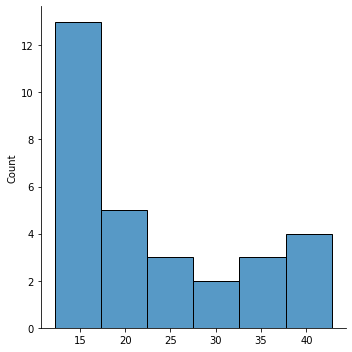

In [20]:
sns.displot(a)

<AxesSubplot:xlabel='Day', ylabel='Retention of i-day'>

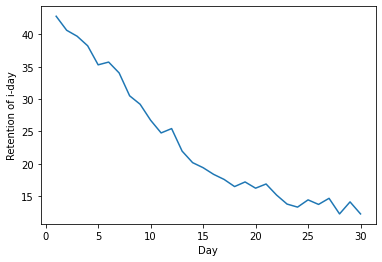

In [21]:
sns.lineplot(data=a.reset_index().rename(columns={'index': 'Day', 0: 'Retention of i-day'}), x='Day', y='Retention of i-day')

In [22]:
b = df_retention_ads.drop(columns=[0]).median()
b

1     37.306738
2     34.602917
3     32.657592
4     31.418625
5     29.671818
6     28.732394
7     26.707255
8     23.636364
9     22.502806
10    20.611552
11    18.577740
12    17.362637
13    16.034353
14    14.043035
15    13.534543
16    12.445605
17    11.602288
18    11.794872
19    10.670090
20    10.103627
21     9.424203
22     8.181027
23     7.257743
24     7.936508
25     7.504272
26     9.067358
27     8.155457
28     8.906526
29     8.820175
30     5.555556
dtype: float64

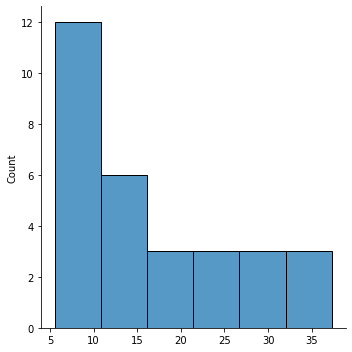

In [23]:
sns.displot(b)

<AxesSubplot:xlabel='Day', ylabel='Retention of i-day'>

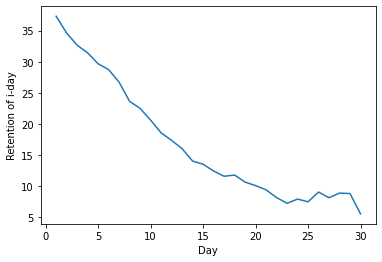

In [24]:
sns.lineplot(data=b.reset_index().rename(columns={'index': 'Day', 0: 'Retention of i-day'}), x='Day', y='Retention of i-day')

<AxesSubplot:xlabel='Day', ylabel='Retention of i-day'>

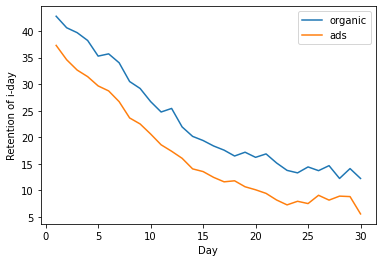

In [25]:
sns.lineplot(data=a.reset_index().rename(columns={'index': 'Day', 0: 'Retention of i-day'}), x='Day', y='Retention of i-day', label='organic')
sns.lineplot(data=b.reset_index().rename(columns={'index': 'Day', 0: 'Retention of i-day'}), x='Day', y='Retention of i-day', label='ads')

**The resulting samples are not normally distributed, to evaluate the statistic significance, we use the Mann-Whitney test**

In [26]:
stats.ttest_ind(a, b)

Ttest_indResult(statistic=2.4795386720133816, pvalue=0.01608222450159301)

In [27]:
U1, p = mannwhitneyu(a, b, method="exact")
print(p)

0.0043130190102278875


**The resulting p-value < 0.05, so we can reject the null hypothesis. Thus, we got a statistically significant difference**

<AxesSubplot:ylabel='Count'>

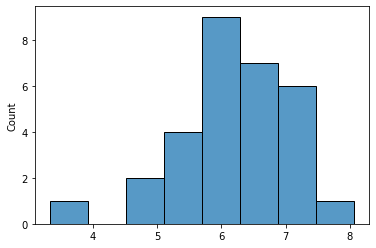

In [28]:
sns.histplot(a-b)

In [29]:
(a-b).median()

6.151850874693283

In [30]:
(a-b).mean()

6.195353153379846

**Conclusion: The overall usage pattern of the app by the two user groups is similar, but the churn dynamics are different. On average, retention of the i-th day for users from the organic group is 6.1% higher than for users from the ads group (a statistically significant difference was obtained when comparing retention by day).**